In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
import yaml
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

In [2]:
# load yaml
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
    DATA_PATH = config.get("data_path")
    if DATA_PATH is None:
        print("ERROR: No data path provided")
    USE_DRIVE = bool(config.get("use_drive", False))

In [3]:
# load from drive if requested
if USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')

In [4]:
team_statistics_df = pd.read_csv(os.path.join(DATA_PATH, "team_statistics.csv"))
team_statistics_df.head()

,gameId,gameDate,teamCity,teamName,teamId,opponentTeamCity,opponentTeamName,opponentTeamId,home,win,...,freeThrowsAttempted,freeThrowsMade,freeThrowsPercentage,reboundsDefensive,reboundsOffensive,reboundsTotal,foulsPersonal,turnovers,plusMinusPoints,numMinutes
0,22401058,2025-03-26 22:00:00,Boston,Celtics,1610612738,Phoenix,Suns,1610612756,0,1,...,22.0,20.0,0.909,37.0,11.0,48.0,18.0,10.0,30.0,240.0
1,22401058,2025-03-26 22:00:00,Phoenix,Suns,1610612756,Boston,Celtics,1610612738,1,0,...,21.0,17.0,0.810,27.0,11.0,38.0,18.0,13.0,-30.0,240.0
2,22401057,2025-03-26 21:00:00,Denver,Nuggets,1610612743,Milwaukee,Bucks,1610612749,1,1,...,22.0,13.0,0.591,38.0,8.0,46.0,12.0,9.0,10.0,240.0
3,22401057,2025-03-26 21:00:00,Milwaukee,Bucks,1610612749,Denver,Nuggets,1610612743,0,0,...,13.0,9.0,0.692,31.0,8.0,39.0,14.0,11.0,-10.0,240.0
4,22401054,2025-03-26 19:30:00,Brooklyn,Nets,1610612751,Toronto,Raptors,1610612761,1,0,...,19.0,16.0,0.842,33.0,10.0,43.0,21.0,19.0,-30.0,240.0


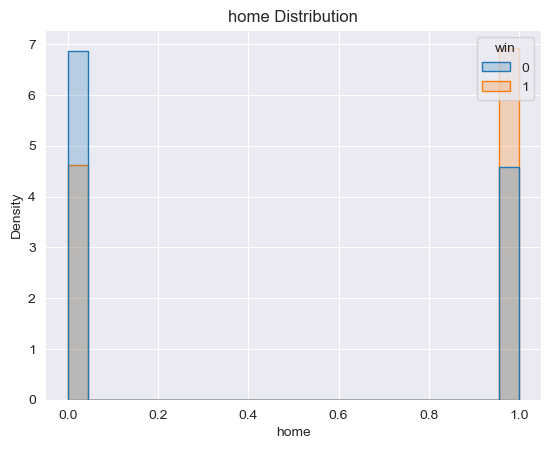

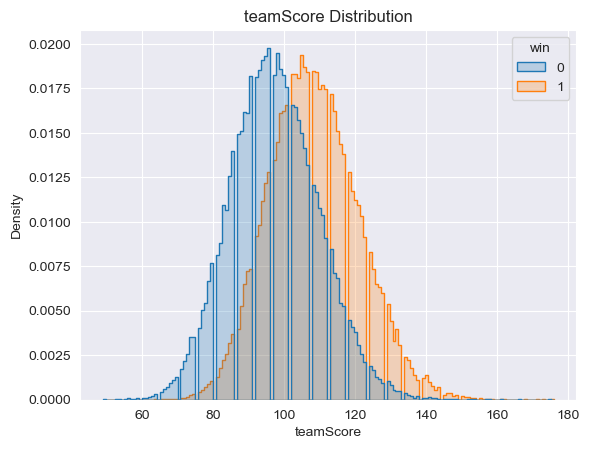

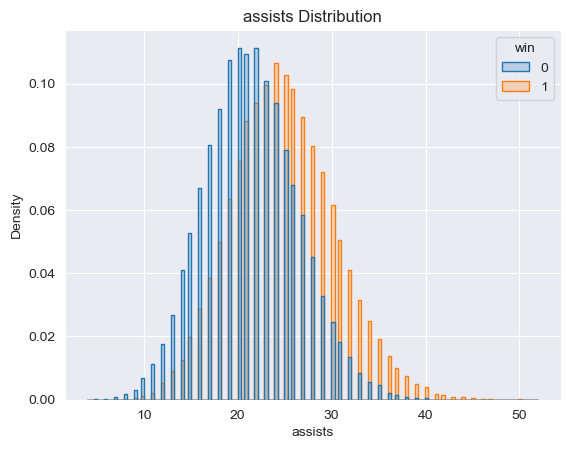

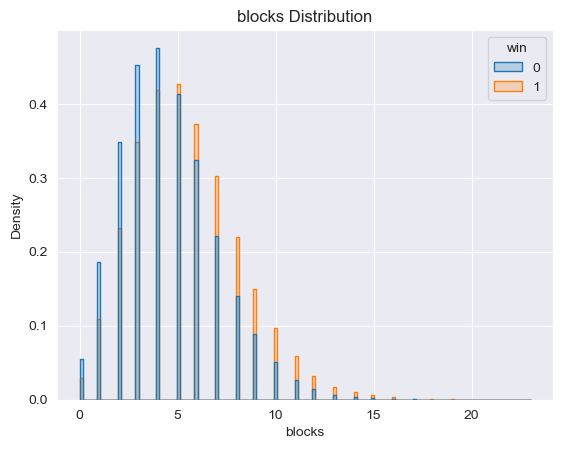

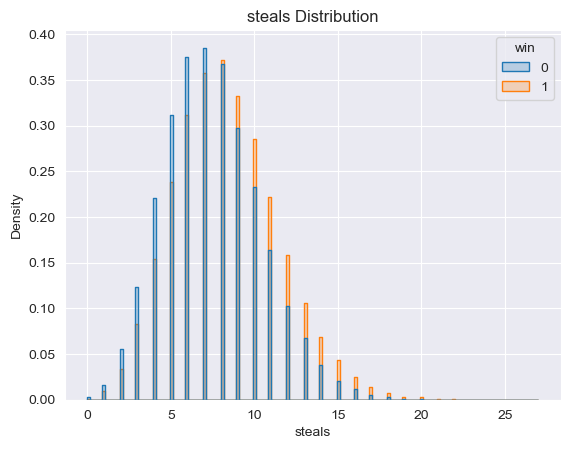

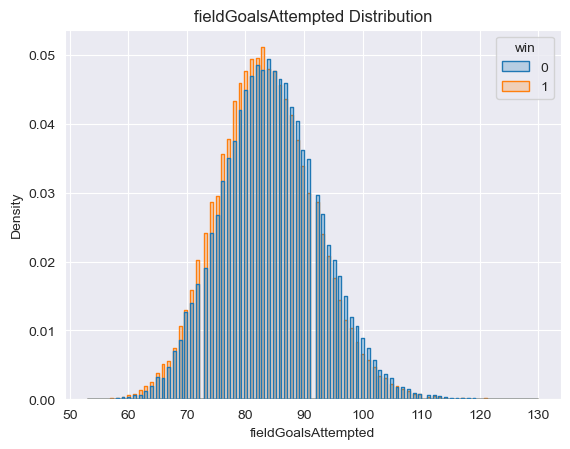

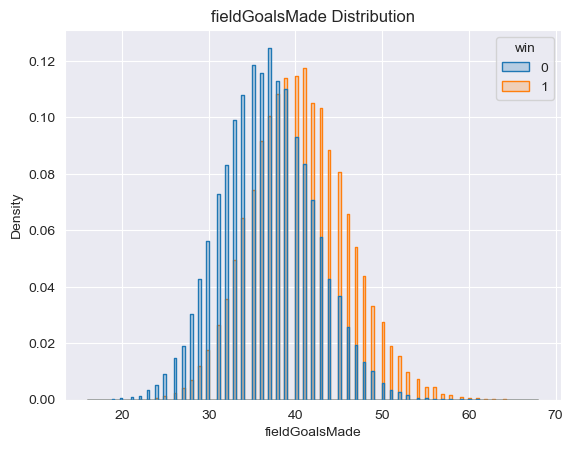

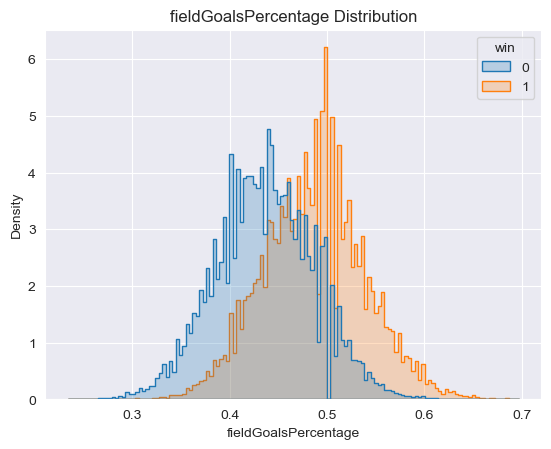

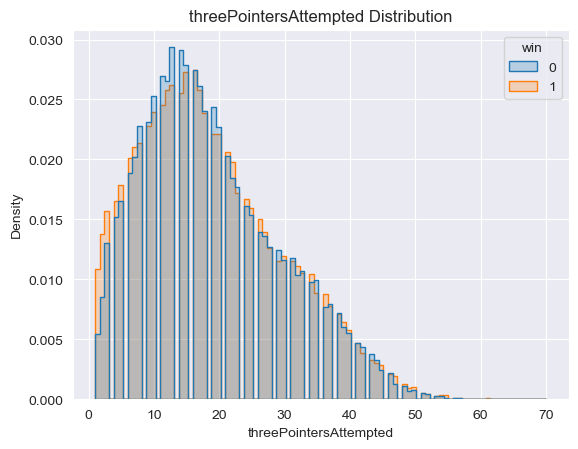

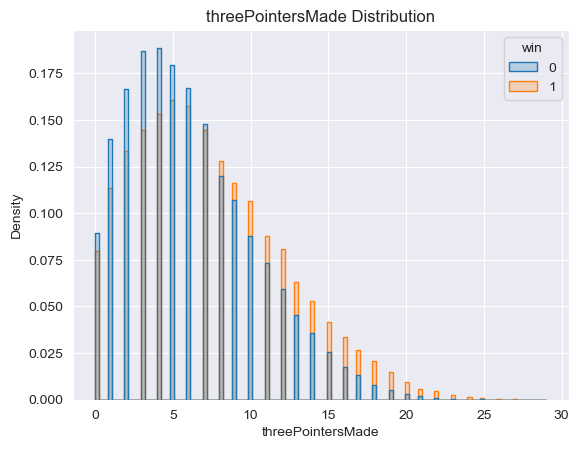

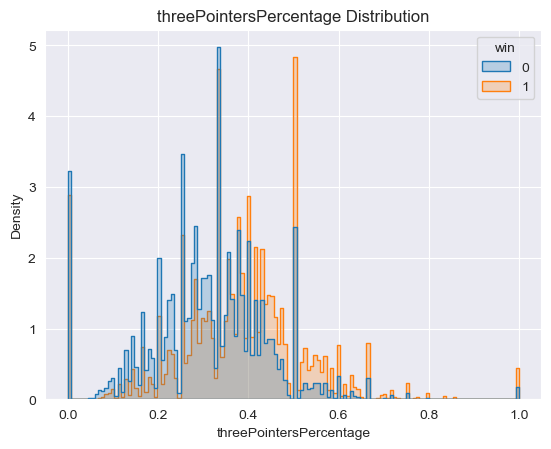

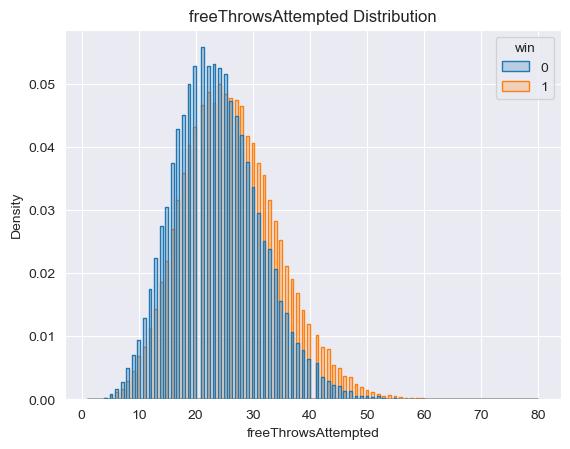

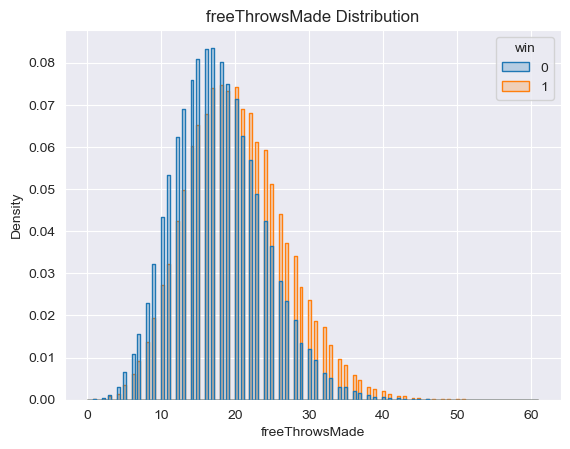

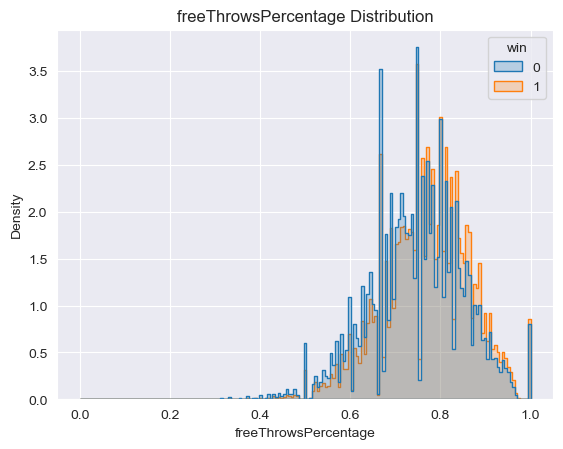

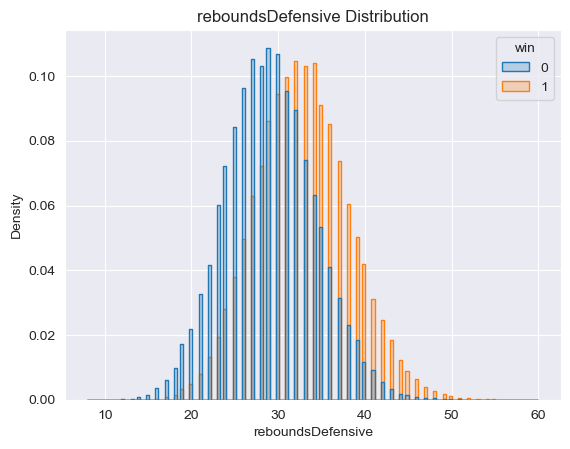

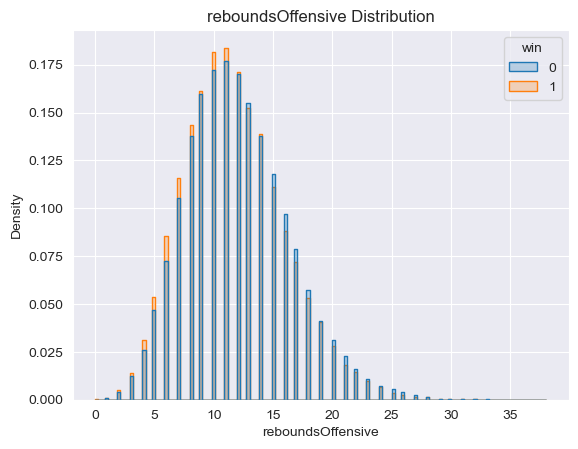

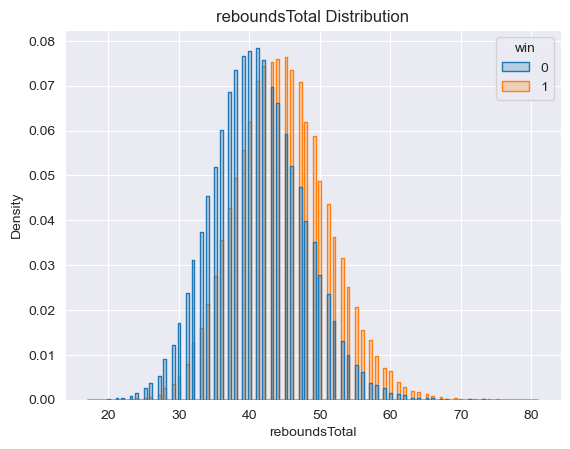

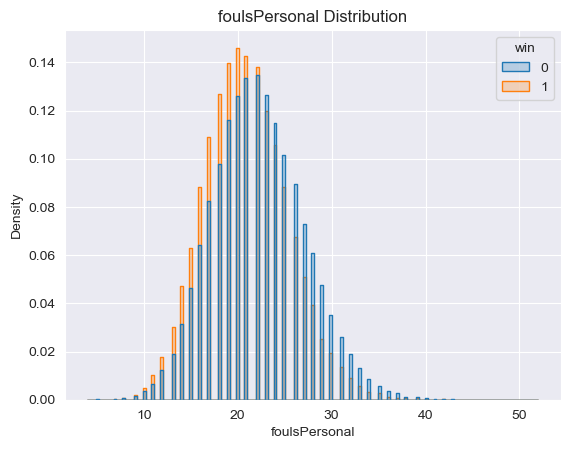

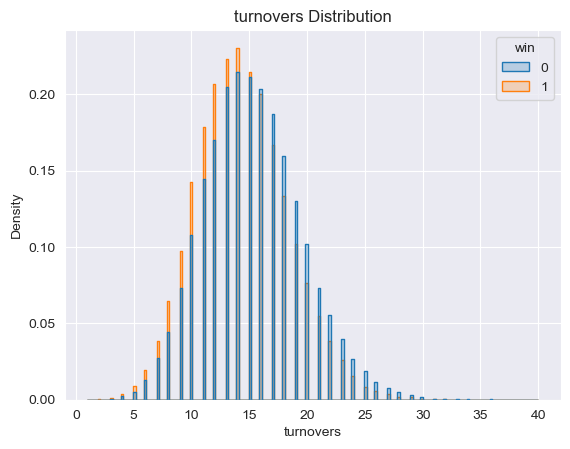

In [5]:
cols = ["home", "teamScore", "assists", "blocks", "steals", "fieldGoalsAttempted", "fieldGoalsMade", "fieldGoalsPercentage", "threePointersAttempted", "threePointersMade", "threePointersPercentage", "freeThrowsAttempted", "freeThrowsMade", "freeThrowsPercentage", "reboundsDefensive", "reboundsOffensive", "reboundsTotal", "foulsPersonal", "turnovers"]

for i, col in enumerate(cols):
    sns.histplot(data=team_statistics_df, x=col, hue='win', element='step', stat='density')
    #sns.histplot(team_statistics_df[col], ax=axs[i])
    plt.title(f"{col} Distribution")
    plt.show()



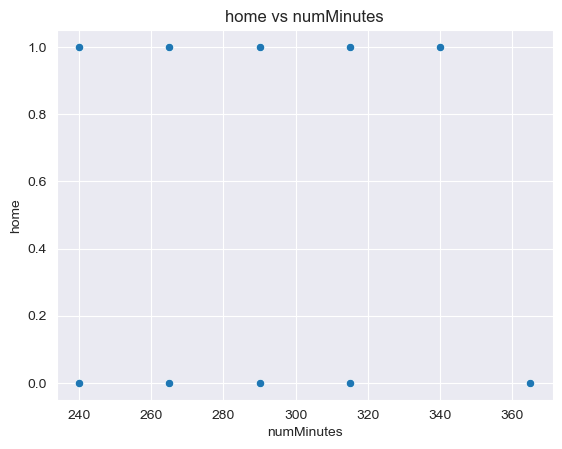

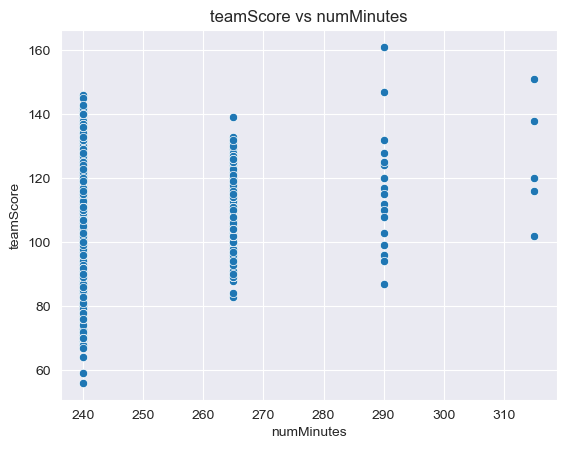

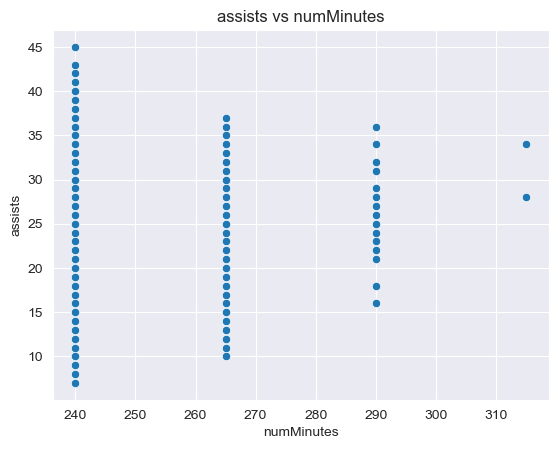

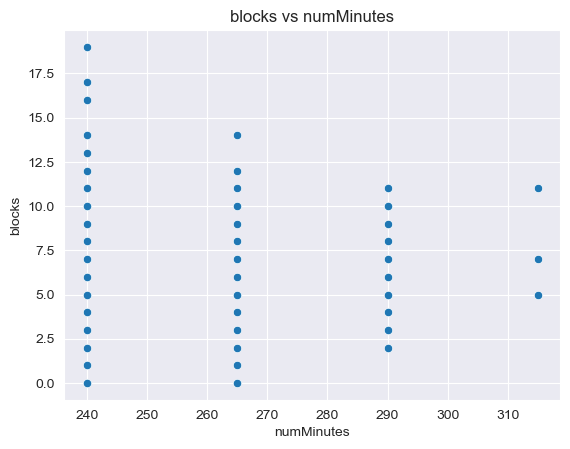

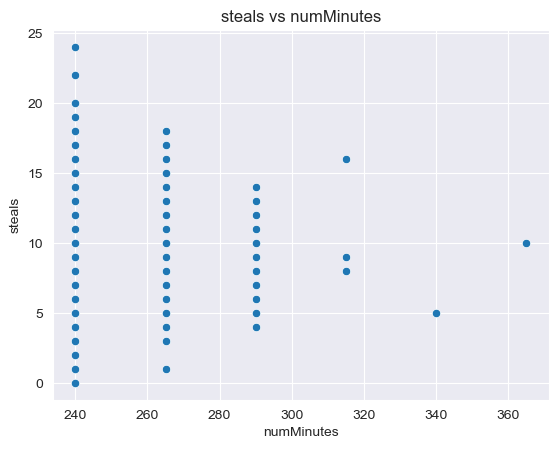

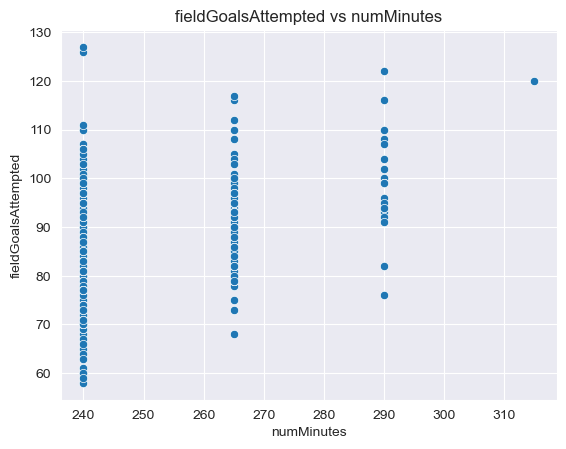

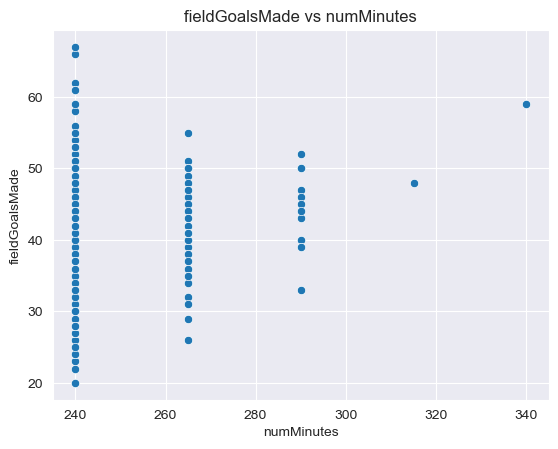

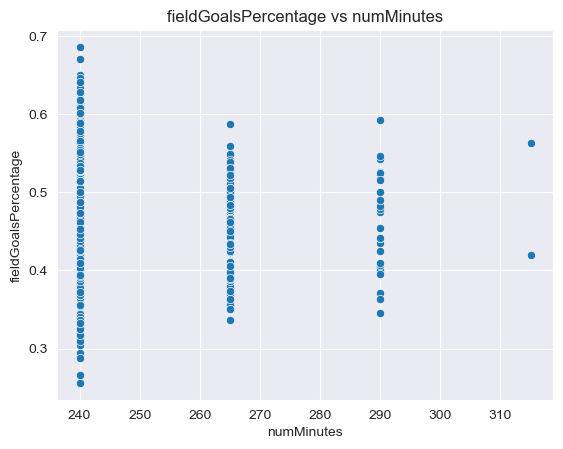

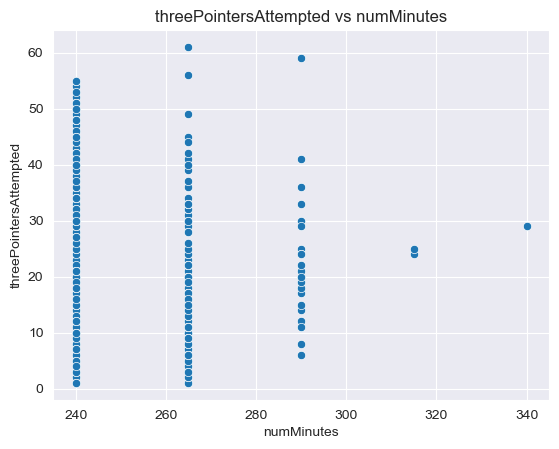

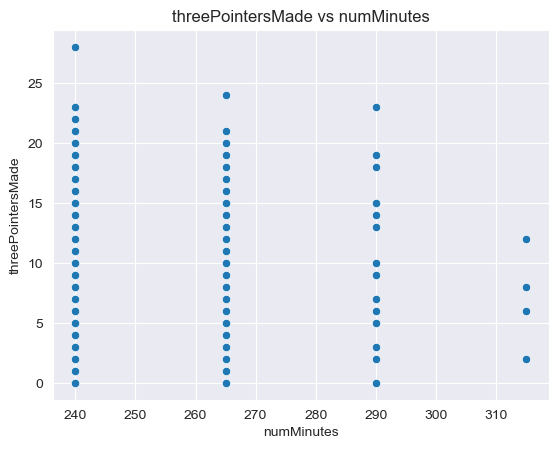

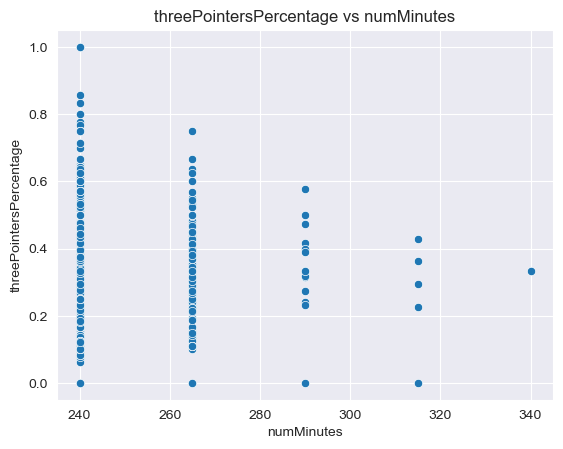

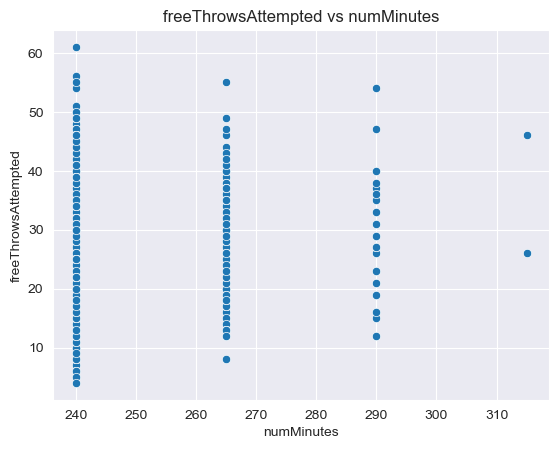

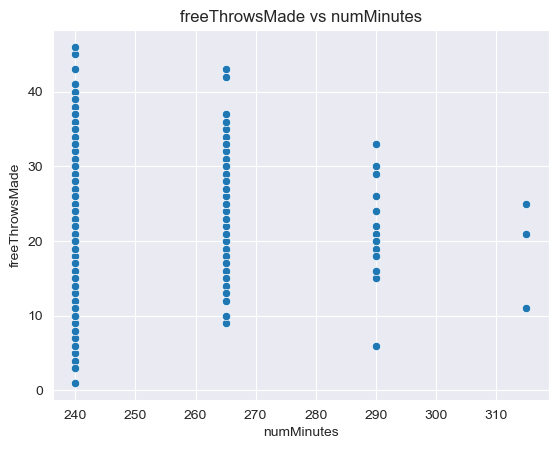

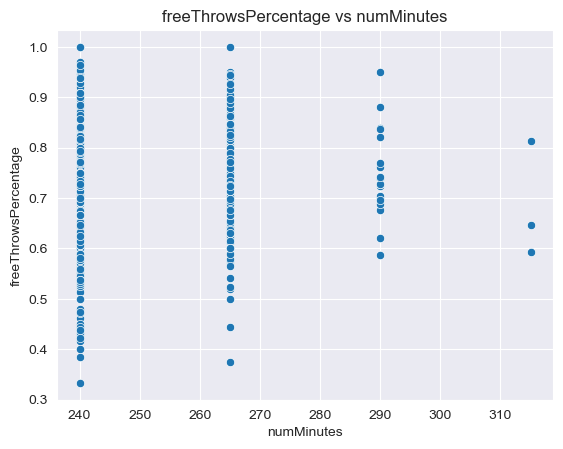

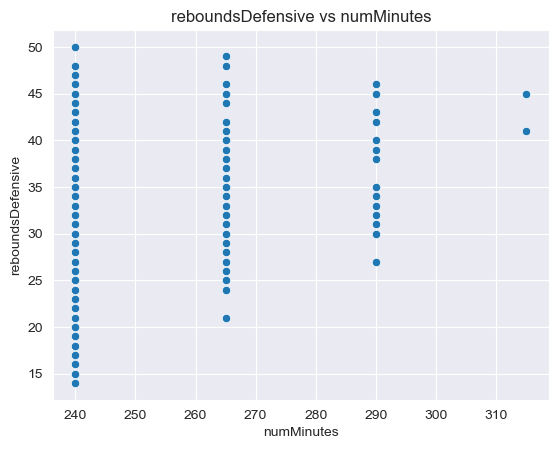

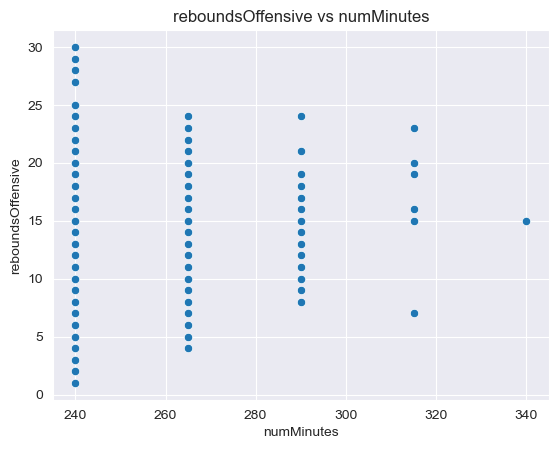

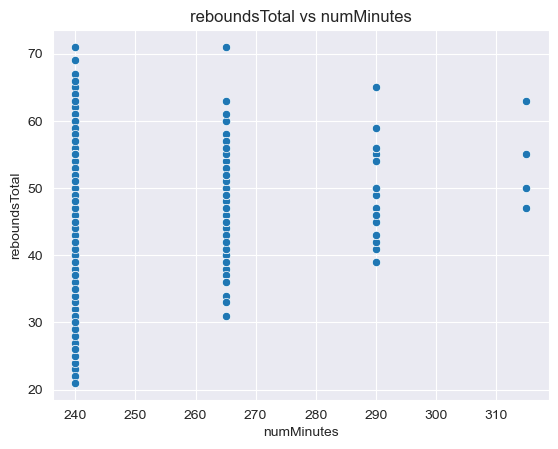

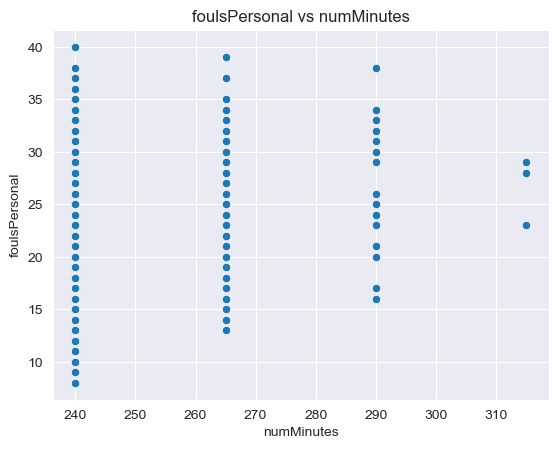

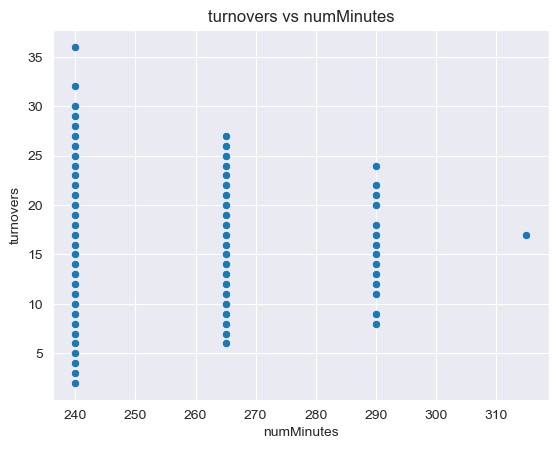

In [6]:
for col in cols:
    sns.scatterplot(x='numMinutes', y=col, data=team_statistics_df.sample(3000))
    plt.title(f'{col} vs numMinutes')
    plt.show()

Since we are dealing with countable variables, such as assists, rebounds, steals etc., if we want to show whether a winning team has more "skill" in this variable than the other, we have to account for the fact that if a team simply has more chances to score, it will have more assists, rebounds, steals etc. even though they are not better at these skills than the other team. This can be seen by the plots above showing that, by playing more minutes in a game (Overtime games for example), the trend seems to go higher for these countable variables, and the same will therefore be true if we can pack more attempts within the same minutes. So, we have to adjust the variables by the amount of possessions a team is playing at.

Conventionally, a possession is defined as a play that ends either in a turnover, a field goal, or a free throw (foul). Additionally, possessions are extended when the team gets an offensive rebound. The formula for possessions is therefore:
$$Possessions = FGA + (0.44 * FTA) + TO - OREB$$
Source: https://support.fastmodelsports.com/support/solutions/articles/9000231009-how-do-we-estimate-pace-and-possessions-

In [7]:
team_statistics_df["possessions"] = team_statistics_df["fieldGoalsAttempted"] + (0.44 * team_statistics_df["freeThrowsAttempted"]) + team_statistics_df["turnovers"] - team_statistics_df["reboundsOffensive"]

With the possessions, we can then normalize the countable variables by the amount of possessions a team is playing at.

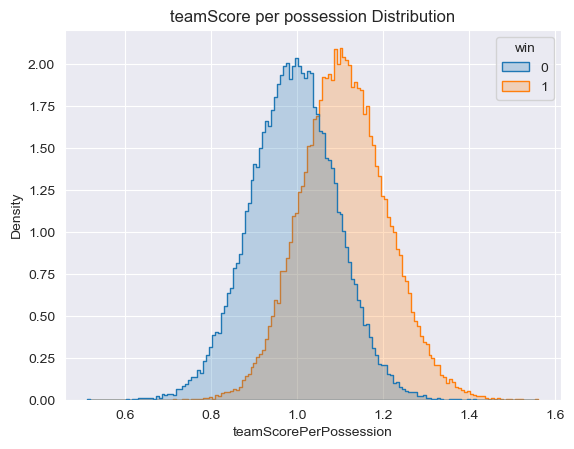

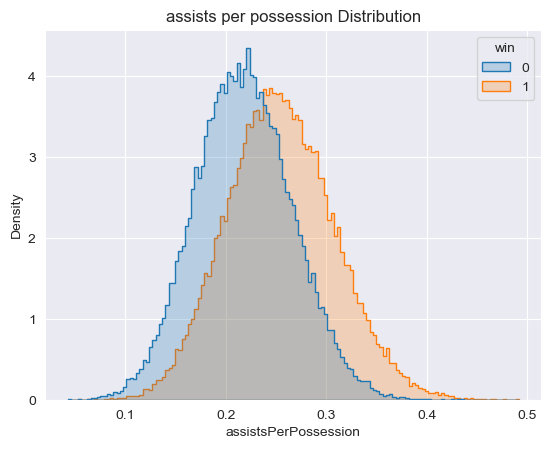

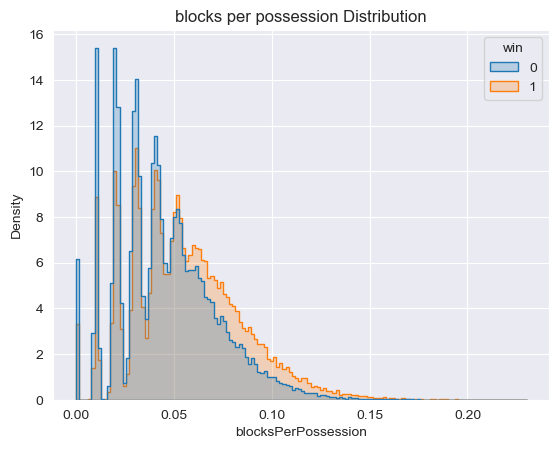

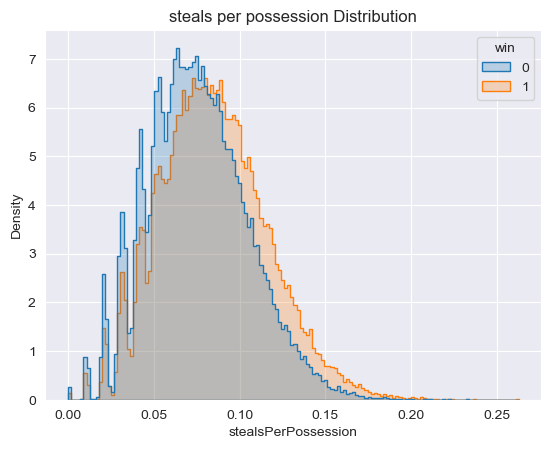

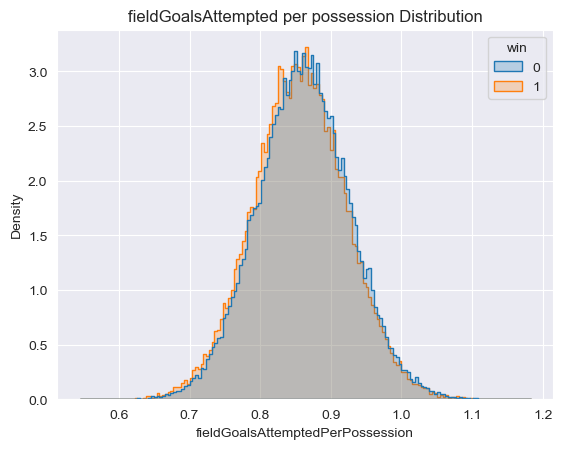

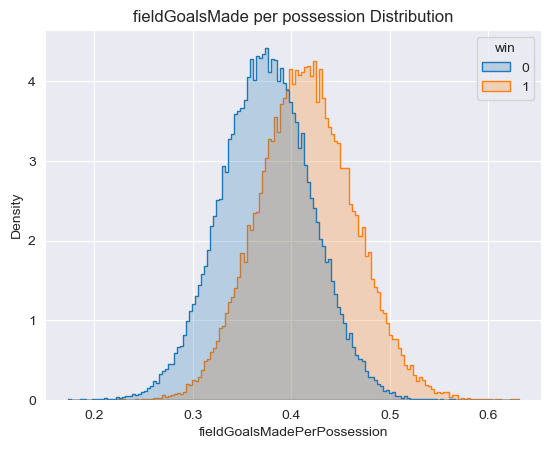

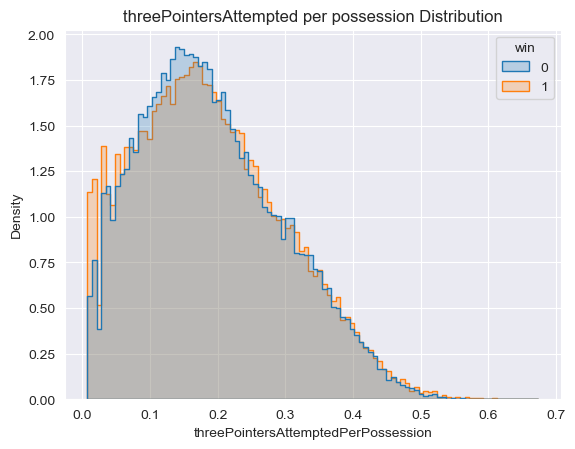

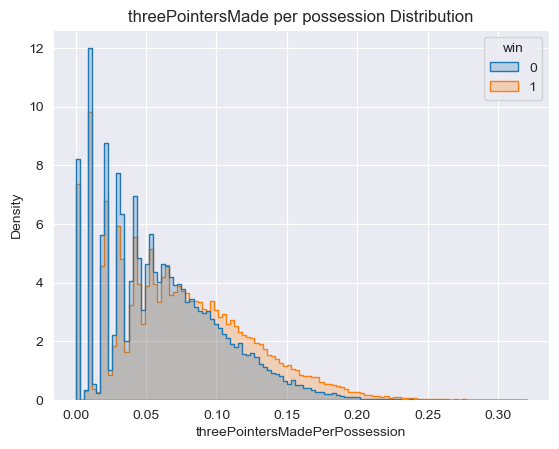

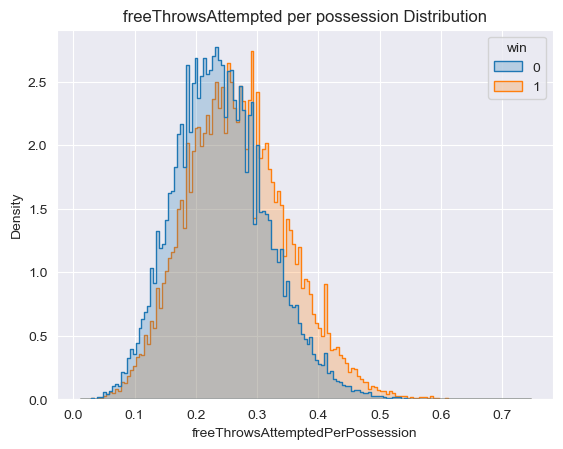

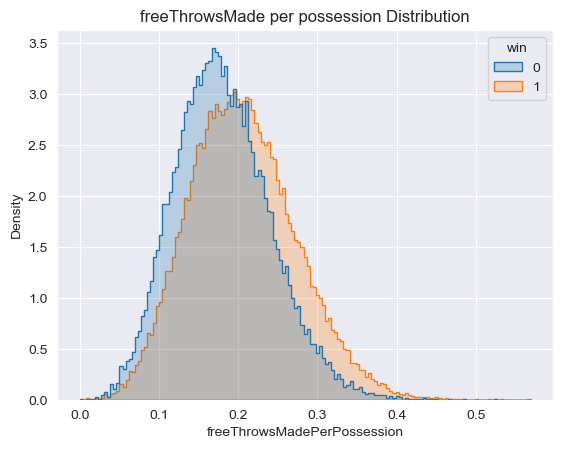

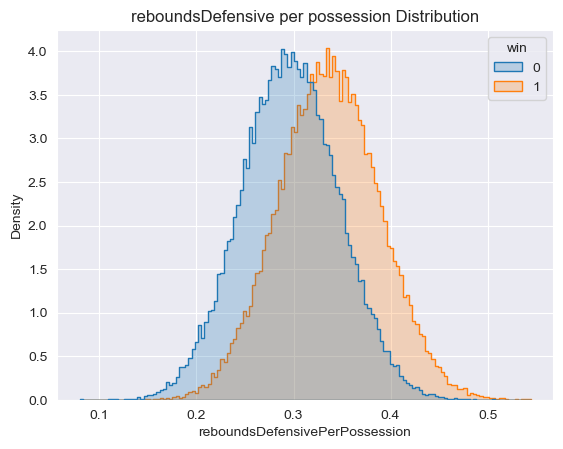

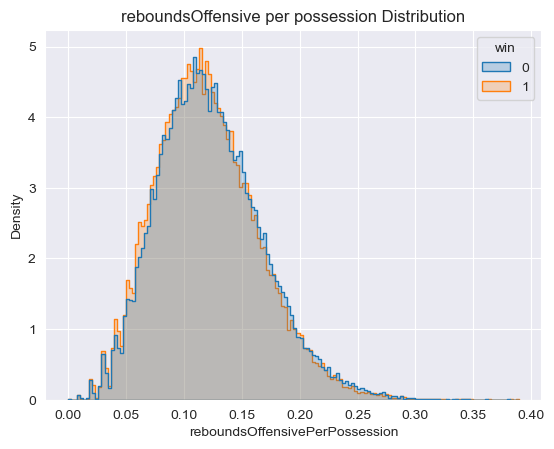

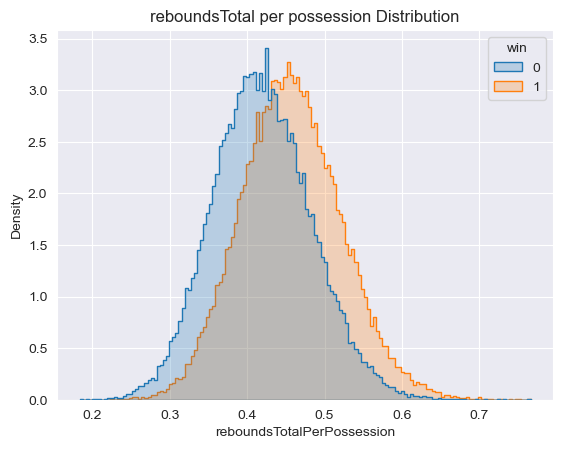

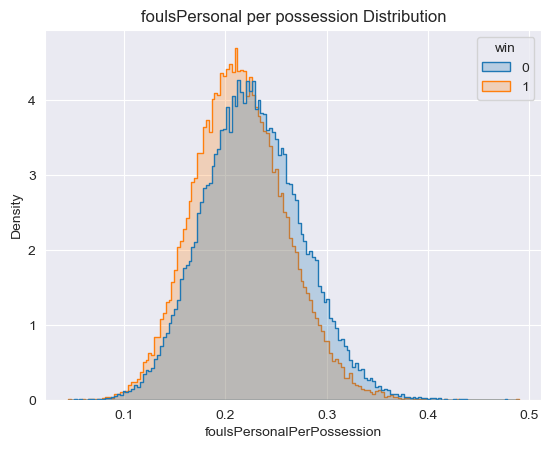

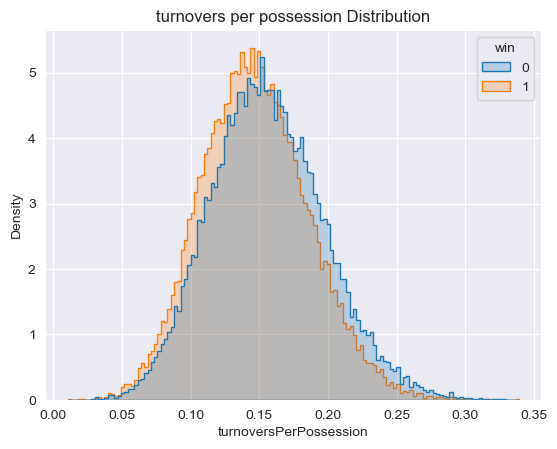

In [8]:
per_possession_cols = ["teamScore", "assists", "blocks", "steals",
                 "fieldGoalsAttempted", "fieldGoalsMade",
                 "threePointersAttempted", "threePointersMade",
                 "freeThrowsAttempted", "freeThrowsMade",
                 "reboundsDefensive", "reboundsOffensive",
                 "reboundsTotal", "foulsPersonal", "turnovers"]

for col in per_possession_cols:
    team_statistics_df[col + "PerPossession"] = team_statistics_df[col] / team_statistics_df["possessions"]
    sns.histplot(data=team_statistics_df, x=col + "PerPossession", hue='win', element='step', stat='density')
    plt.title(f"{col} per possession Distribution")
    plt.show()

In [9]:
# Save the dataframe to a csv file
team_statistics_df.to_csv(os.path.join(DATA_PATH, "team_statistics_per_possession.csv"), index=False)

We can now move on to testing:

In [10]:
win = team_statistics_df[team_statistics_df["win"] == 1]
loss = team_statistics_df[team_statistics_df["win"] == 0]
paired = pd.merge(win, loss, on=["gameId"], suffixes=("_win", "_loss"))

In [11]:
cols = [c for c in team_statistics_df.columns if c.endswith("PerPossession") or c.endswith("Percentage")]

differences = paired[[f"{col}_win" for col in cols]].values - paired[[f"{col}_loss" for col in cols]].values
differences = pd.DataFrame(differences, columns=cols)

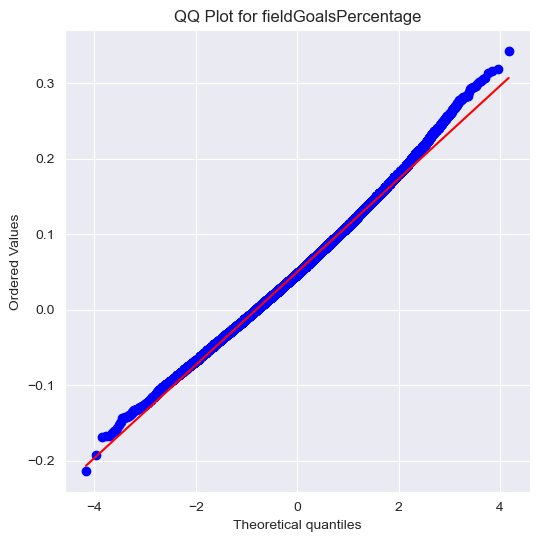

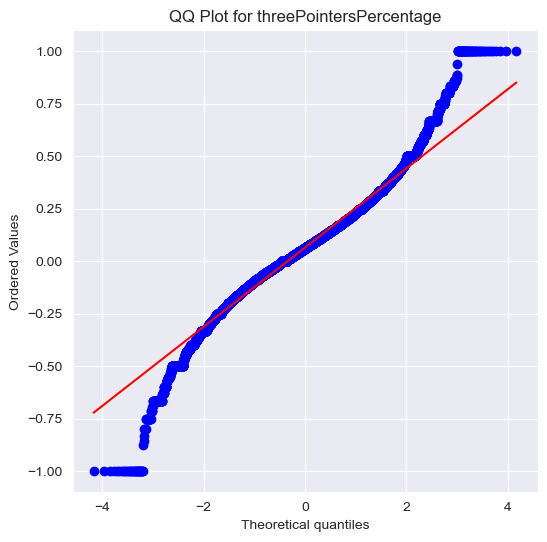

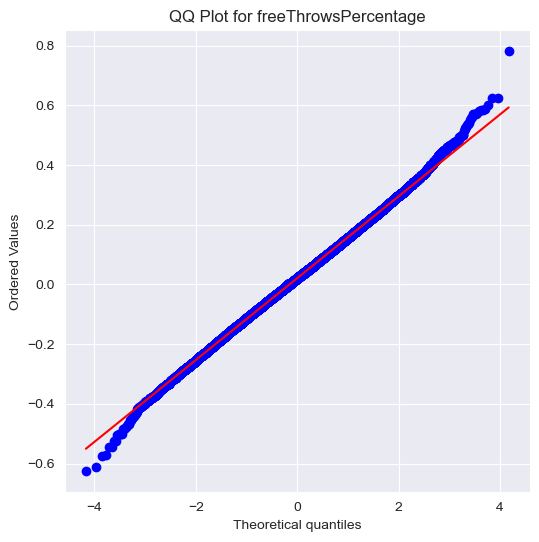

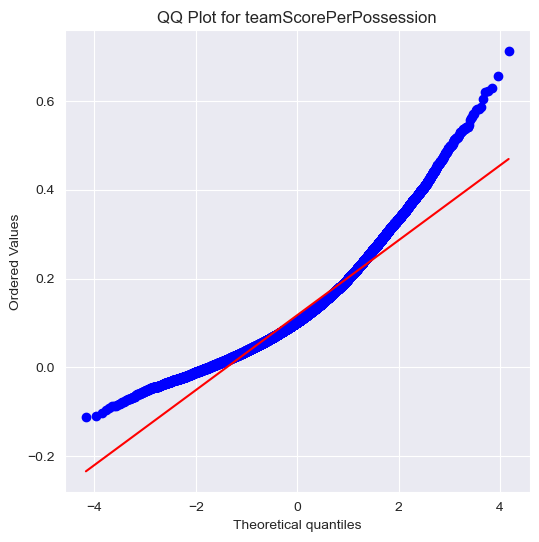

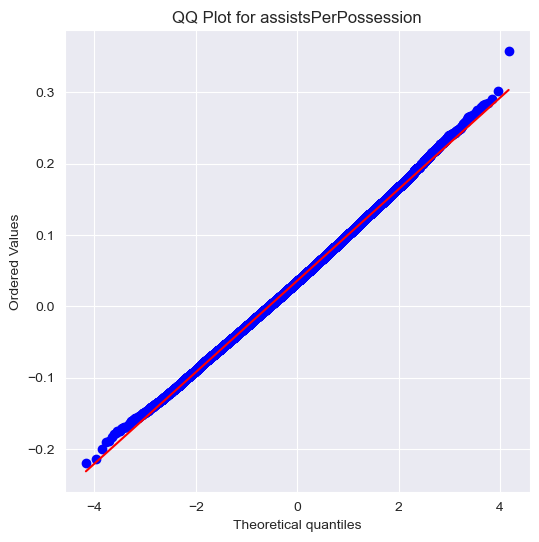

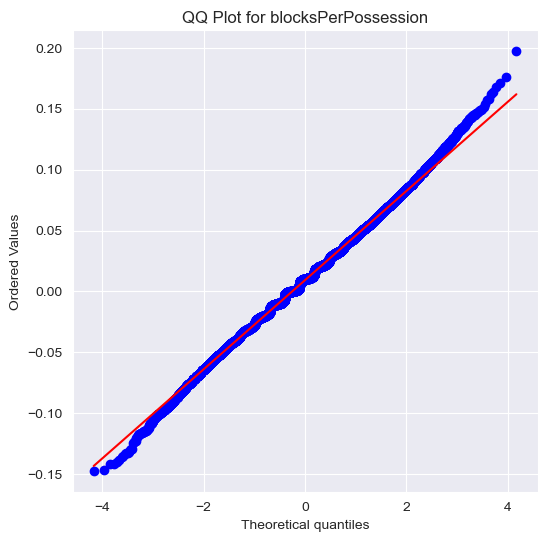

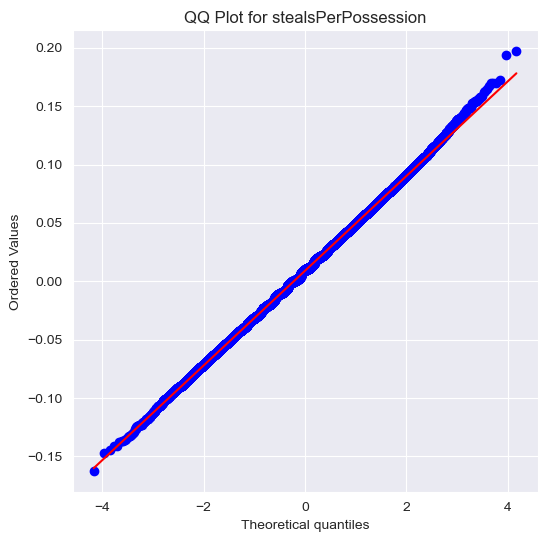

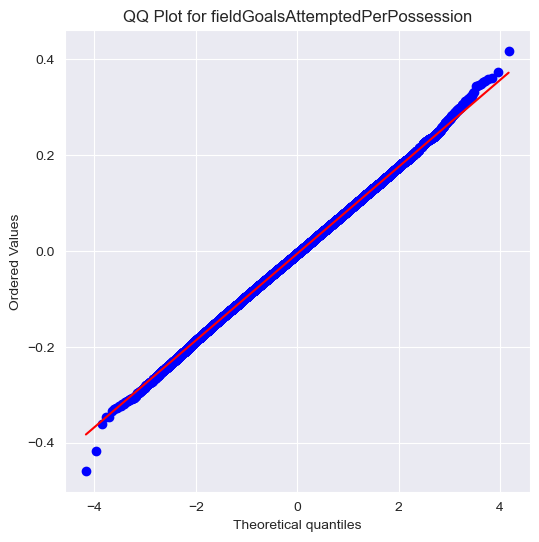

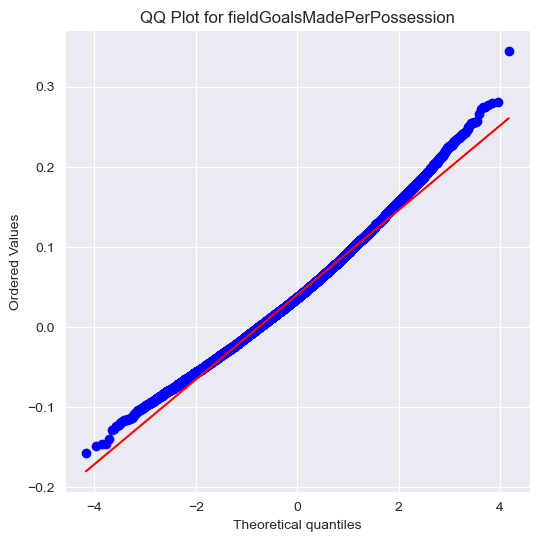

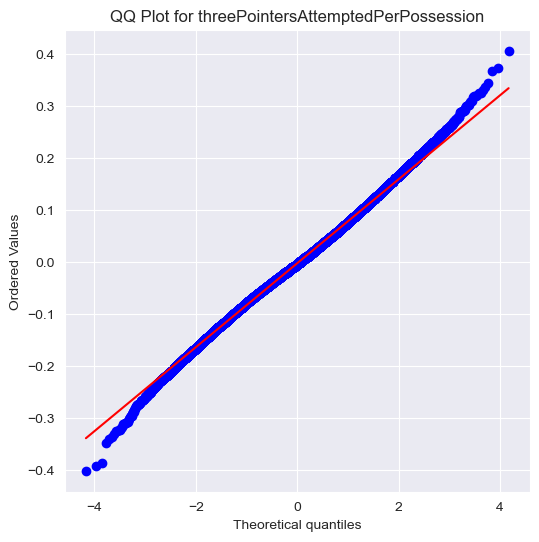

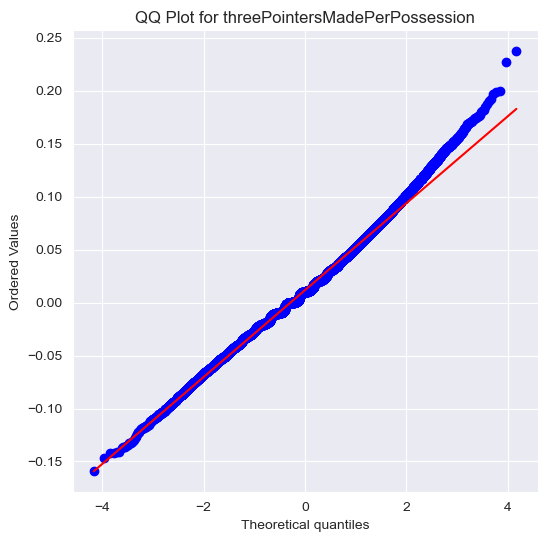

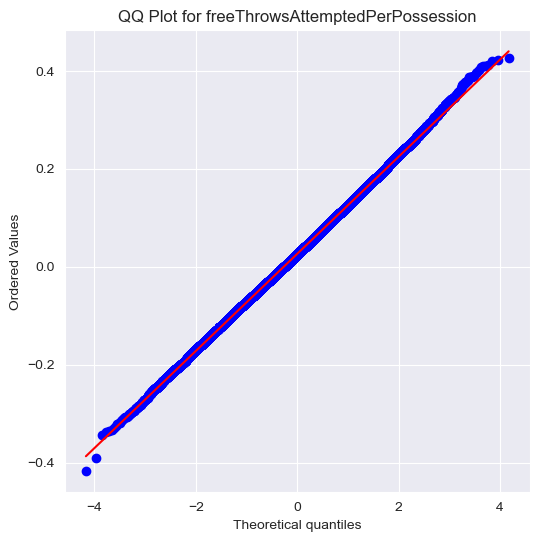

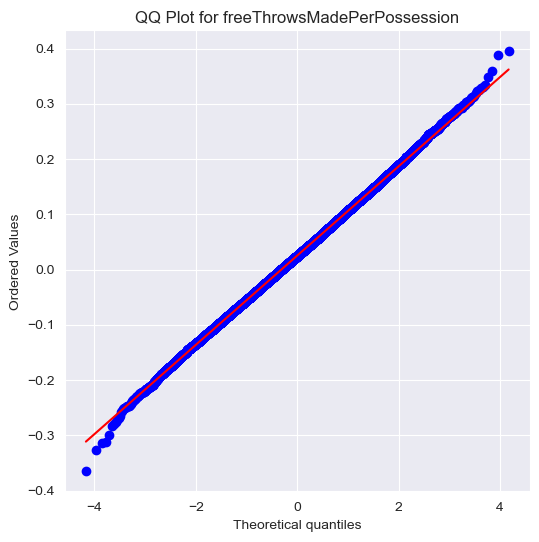

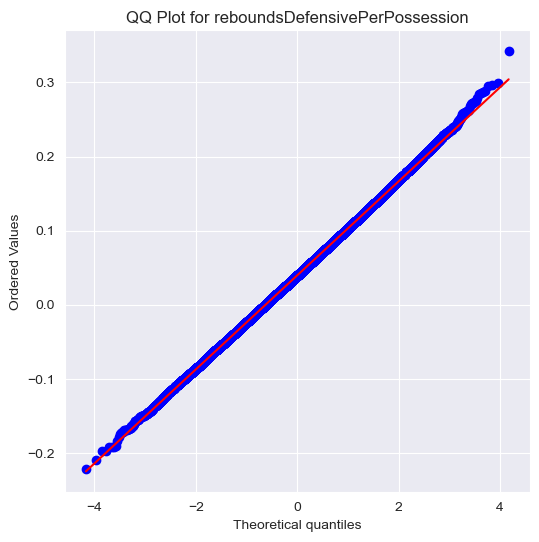

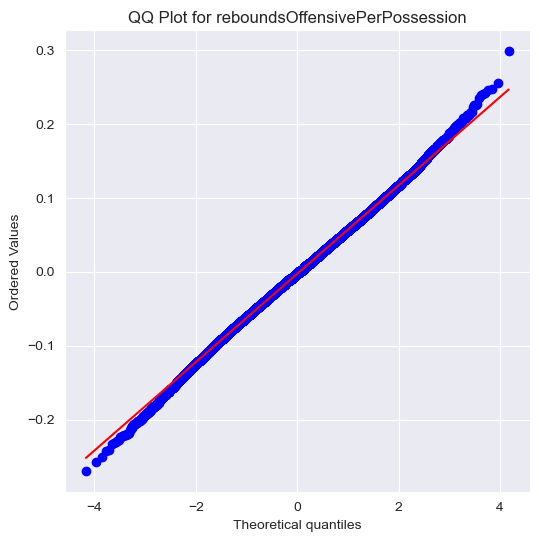

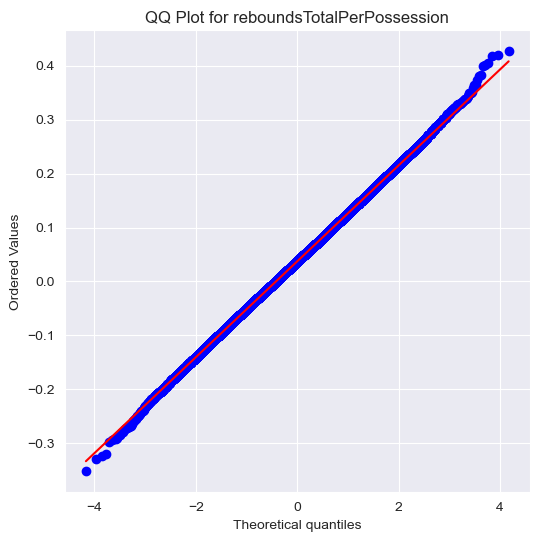

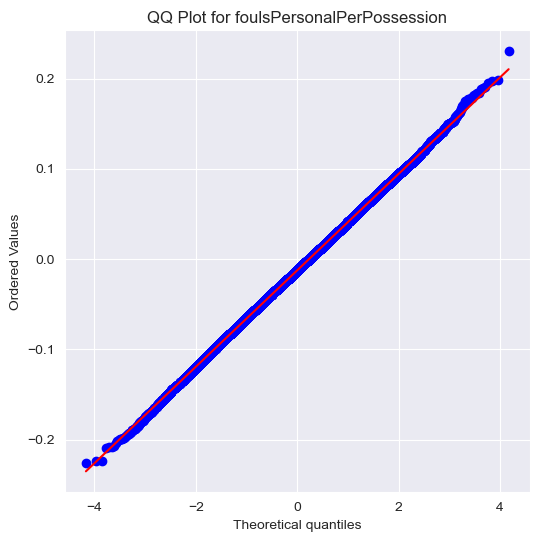

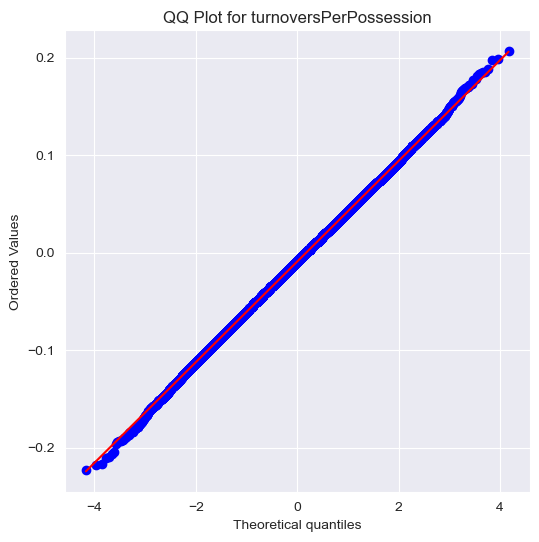

In [12]:
# Plot QQ Plots
for col in differences.columns:
    plt.figure(figsize=(6, 6))
    stats.probplot(differences[col], dist="norm", plot=plt)
    plt.title(f"QQ Plot for {col}")
    plt.show()

All distributions do follow a Normal Distributions when inspecting the QQ-Plots apart from teamScorePerPossessions. The only outlier is the threePointersPercentage, whose QQ-Plot suggests that the distribution has heavy tails. This can be attributed to the fact that three pointers weren't commonly thrown in earlier years (such as the 80s, 90s etc.) and therefore there were a lot of games where no threes were taken or 0/1 or 1/1 threes were made, leading to the heavy tails.

In [13]:
# Print rows where threePointersPercentage == 1.0
team_statistics_df[team_statistics_df["threePointersPercentage"] == 1.0]

,gameId,gameDate,teamCity,teamName,teamId,opponentTeamCity,opponentTeamName,opponentTeamId,home,win,...,fieldGoalsMadePerPossession,threePointersAttemptedPerPossession,threePointersMadePerPossession,freeThrowsAttemptedPerPossession,freeThrowsMadePerPossession,reboundsDefensivePerPossession,reboundsOffensivePerPossession,reboundsTotalPerPossession,foulsPersonalPerPossession,turnoversPerPossession
43693,20600593,2007-01-20 19:00:00,Atlanta,Hawks,1610612737,Charlotte,Bobcats,1610612766,0,0,...,0.406204,0.012309,0.012309,0.258493,0.221566,0.209257,0.123092,0.332349,0.283112,0.209257
44125,20600375,2006-12-20 22:30:00,Los Angeles,Clippers,1610612746,Toronto,Raptors,1610612761,1,0,...,0.424297,0.011166,0.011166,0.267977,0.212148,0.334971,0.156320,0.491291,0.234480,0.100491
47551,20401112,2005-04-06 20:00:00,Denver,Nuggets,1610612743,New Orleans,Hornets,1610612740,0,1,...,0.348690,0.031699,0.031699,0.327557,0.264159,0.359256,0.073964,0.433221,0.221893,0.126796
48106,20400833,2005-02-28 21:00:00,Los Angeles,Clippers,1610612746,Utah,Jazz,1610612762,0,0,...,0.357654,0.023844,0.023844,0.321888,0.286123,0.238436,0.166905,0.405341,0.298045,0.190749
52284,20201105,2003-04-06 15:30:00,Philadelphia,76ers,1610612755,Sacramento,Kings,1610612758,1,0,...,0.288500,0.009948,0.009948,0.328293,0.218862,0.318345,0.169121,0.487465,0.179069,0.159172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90430,28500021,1985-10-27 20:00:00,Portland,Trail Blazers,1610612757,Golden State,Warriors,1610612744,1,1,...,0.426807,0.018162,0.018162,0.208863,0.181620,0.236106,0.136215,0.372321,0.263349,0.236106
90464,28300590,1984-02-15 20:00:00,Dallas,Mavericks,1610612742,Philadelphia,76ers,1610612755,1,1,...,0.446889,0.008594,0.008594,0.163286,0.120316,0.232039,0.068752,0.300791,0.197662,0.223444
90475,28300017,1983-10-29 20:00:00,Philadelphia,76ers,1610612755,Indiana,Pacers,1610612754,0,1,...,0.390486,0.008875,0.008875,0.417110,0.310614,0.275115,0.159744,0.434860,0.283990,0.239617
90486,28100566,1982-02-14 20:00:00,Milwaukee,Bucks,1610612749,Cleveland,Cavaliers,1610612739,0,1,...,0.495751,0.010117,0.010117,0.364225,0.263051,0.303521,0.080939,0.384460,0.263051,0.151760


In [14]:
# Perform ttest of differences
from statsmodels.stats.multitest import multipletests
import pingouin as pg

results = []
for col in cols:
    diffs = differences[col]

    if col == "teamScorePerPossession":
        res = pg.wilcoxon(diffs)
        statistic = res['W-val'].iloc[0]
        p_value = res['p-val'].iloc[0]
        effect_size = res['RBC'].iloc[0]
    else:
        statistic, p_value = stats.ttest_1samp(diffs, 0)
        effect_size = diffs.mean() / diffs.std(ddof=1)
    results.append({
        'col': col,
        'mean_diff': diffs.mean(),
        'std_diff': diffs.std(ddof=1),
        't_statistic': statistic,
        'p_value': p_value,
        'effect_size': effect_size
    })

results_df = pd.DataFrame(results)

# Bonferri Correction
results_df['corrected_p_value'] = multipletests(results_df['p_value'], method='bonferroni')[1]
results_df = results_df.sort_values('effect_size', ascending=False).reset_index(drop=True)
results_df

,col,mean_diff,std_diff,t_statistic,p_value,effect_size,corrected_p_value
0,teamScorePerPossession,0.117938,0.086893,5.746890e+06,0.000000e+00,0.988535,0.000000e+00
1,fieldGoalsPercentage,0.050014,0.061695,1.715419e+02,0.000000e+00,0.810668,0.000000e+00
2,fieldGoalsMadePerPossession,0.040324,0.053101,1.606879e+02,0.000000e+00,0.759374,0.000000e+00
3,reboundsDefensivePerPossession,0.039940,0.063379,1.333482e+02,0.000000e+00,0.630173,0.000000e+00
4,assistsPerPossession,0.036166,0.064055,1.194733e+02,0.000000e+00,0.564603,0.000000e+00
5,reboundsTotalPerPossession,0.037491,0.088936,8.920243e+01,0.000000e+00,0.421550,0.000000e+00
6,threePointersPercentage,0.065415,0.191118,7.242699e+01,0.000000e+00,0.342273,0.000000e+00
7,freeThrowsMadePerPossession,0.025506,0.080819,6.678222e+01,0.000000e+00,0.315597,0.000000e+00
8,threePointersMadePerPossession,0.011794,0.041182,6.059972e+01,0.000000e+00,0.286380,0.000000e+00
9,freeThrowsAttemptedPerPossession,0.026752,0.099195,5.706731e+01,0.000000e+00,0.269687,0.000000e+00


We have also performed bonferri correction to adjust for the fact we have been running multiple tests, but they are all highly significant results. We have also used Cohen's d metric to identify the effect size, where a value of 0.2 represents a small, 0.5 a medium and 0.8 a large effect. The exception is the teamScore, where because of non-normality we have performed a wilcoxon test with Biserial-Rank effect size, where 0.1 is small, 0.3 is medium and 0.5 is large.
From the table we can identify that the largest differences between winning and losing teams are the team score unsurprisingly. Another interesting note is that defensive rebounds are quite a bit more important than assists, indicating that perhaps teamplay isn't quite as important. Another interesting fact is that turnoversPerPossession does not have a high effect size (-0.16), indicating that even if a team commits a lot of turnovers isn't quite as punishing.

threePointersPercentage does not have a huge effect size, but given the heavy tails due to the already mentioned facts, I wanted to explore what happens if we limit the years to since 2000.

In [15]:
# Select games where gameDate has 2000 or later in it
team_statistics_df['gameDate'] = pd.to_datetime(team_statistics_df['gameDate'])

team_statistics_df_2000 = team_statistics_df[team_statistics_df["gameDate"].dt.year >= 2010]
team_statistics_df_2000.head()

,gameId,gameDate,teamCity,teamName,teamId,opponentTeamCity,opponentTeamName,opponentTeamId,home,win,...,fieldGoalsMadePerPossession,threePointersAttemptedPerPossession,threePointersMadePerPossession,freeThrowsAttemptedPerPossession,freeThrowsMadePerPossession,reboundsDefensivePerPossession,reboundsOffensivePerPossession,reboundsTotalPerPossession,foulsPersonalPerPossession,turnoversPerPossession
0,22401058,2025-03-26 22:00:00,Boston,Celtics,1610612738,Phoenix,Suns,1610612756,0,1,...,0.460688,0.532351,0.225225,0.225225,0.204750,0.378788,0.112613,0.491400,0.184275,0.102375
1,22401058,2025-03-26 22:00:00,Phoenix,Suns,1610612756,Boston,Celtics,1610612738,1,0,...,0.366450,0.417345,0.132329,0.213762,0.173046,0.274837,0.111971,0.386808,0.183225,0.132329
2,22401057,2025-03-26 21:00:00,Denver,Nuggets,1610612743,Milwaukee,Bucks,1610612749,1,1,...,0.486691,0.367501,0.158919,0.218514,0.129122,0.377433,0.079460,0.456893,0.119190,0.089392
3,22401057,2025-03-26 21:00:00,Milwaukee,Bucks,1610612749,Denver,Nuggets,1610612743,0,0,...,0.470733,0.378633,0.163733,0.133033,0.092100,0.317233,0.081867,0.399099,0.143266,0.112567
4,22401054,2025-03-26 19:30:00,Brooklyn,Nets,1610612751,Toronto,Raptors,1610612761,1,0,...,0.297049,0.392871,0.076658,0.182062,0.153315,0.316213,0.095822,0.412035,0.201227,0.182062


In [16]:
win_2000 = team_statistics_df_2000[team_statistics_df_2000["win"] == 1]
loss_2000 = team_statistics_df_2000[team_statistics_df_2000["win"] == 0]
paired_2000 = pd.merge(win_2000, loss_2000, on=["gameId"], suffixes=("_win", "_loss"))

In [17]:
cols = [c for c in team_statistics_df_2000.columns if c.endswith("PerPossession") or c.endswith("Percentage")]
differences_2000 = paired_2000[[f"{col}_win" for col in cols]].values - paired_2000[[f"{col}_loss" for col in cols]].values
differences_2000 = pd.DataFrame(differences_2000, columns=cols)

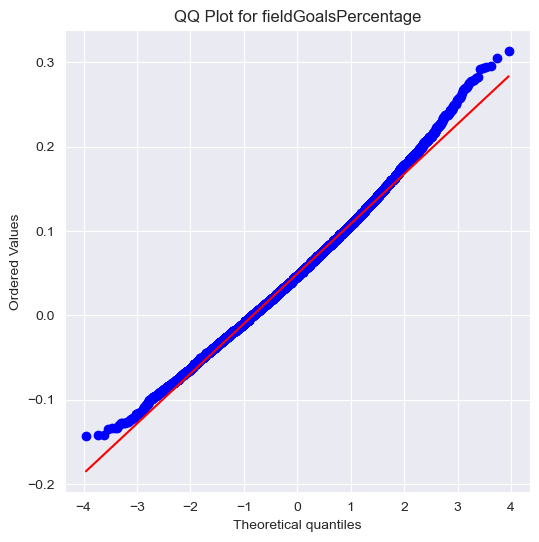

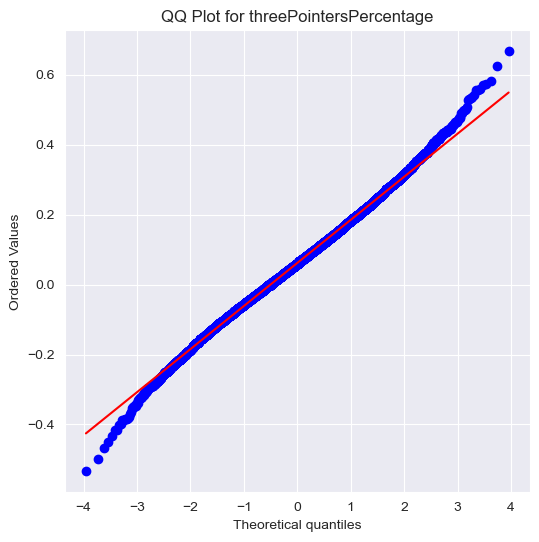

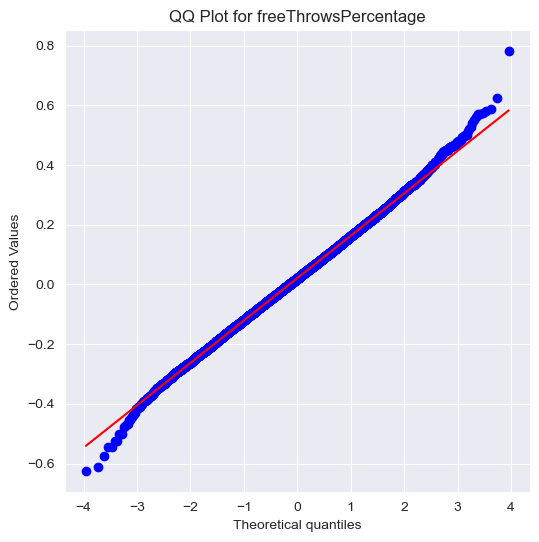

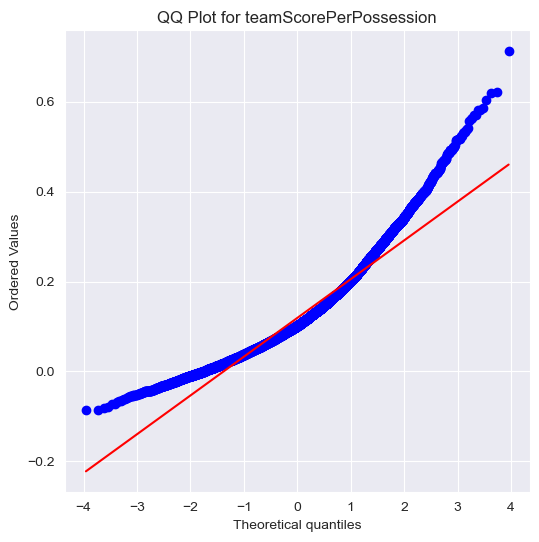

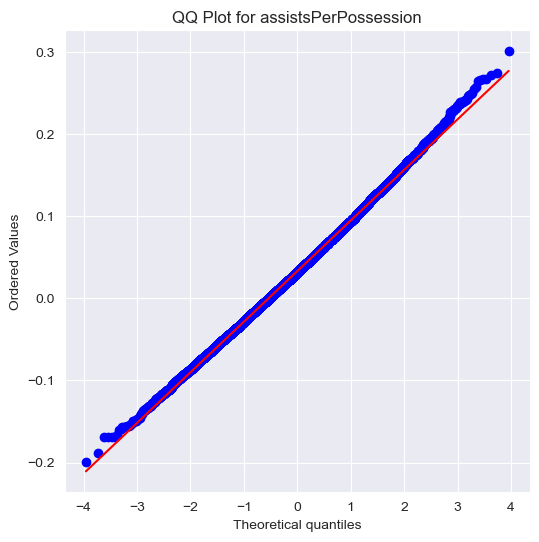

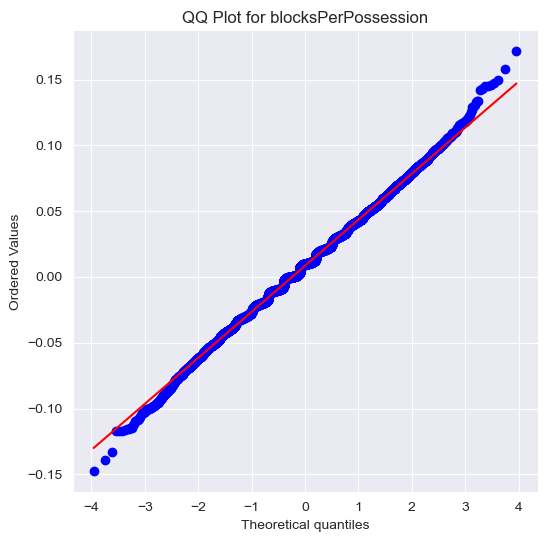

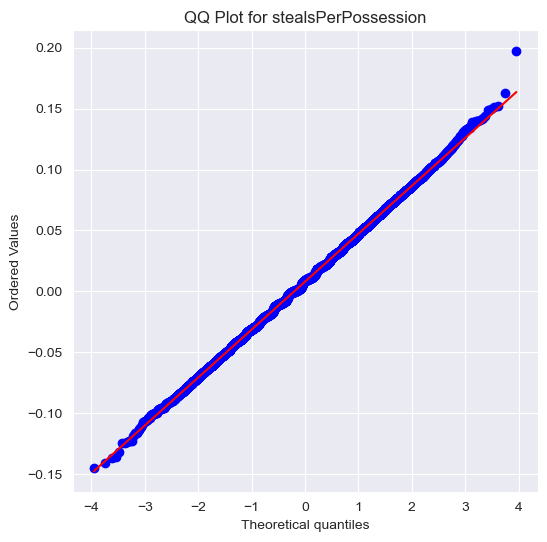

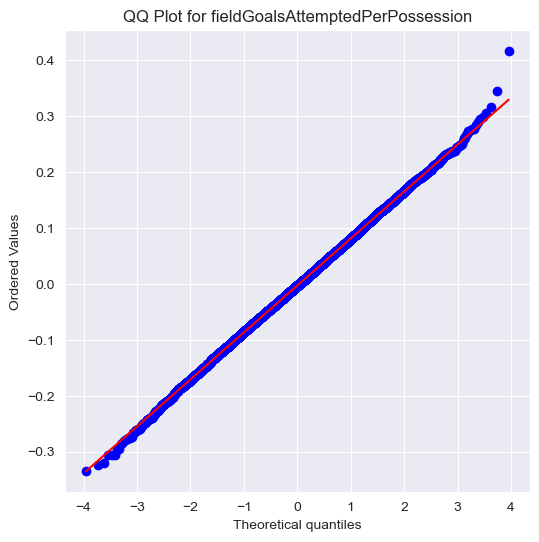

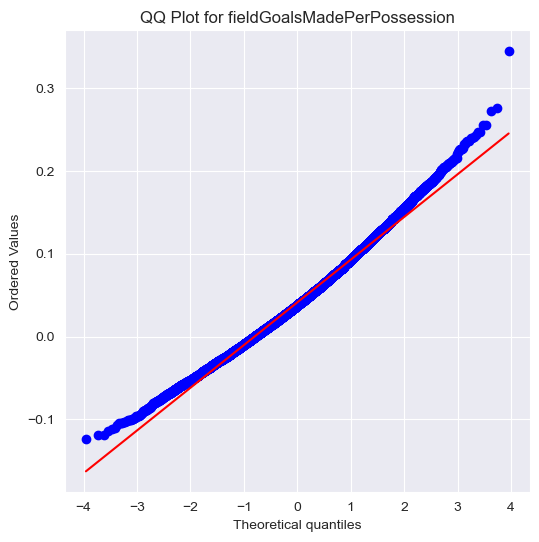

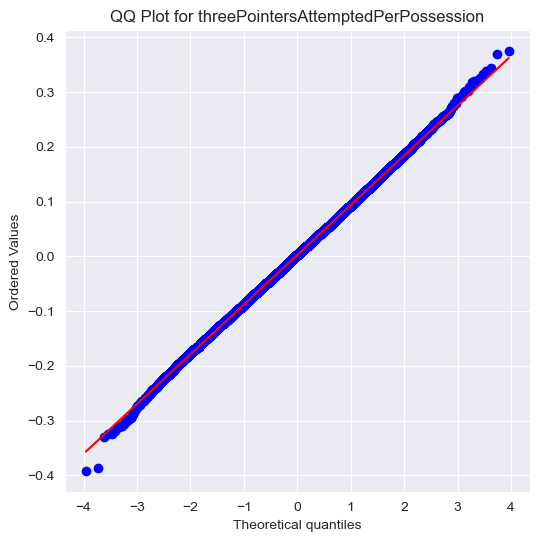

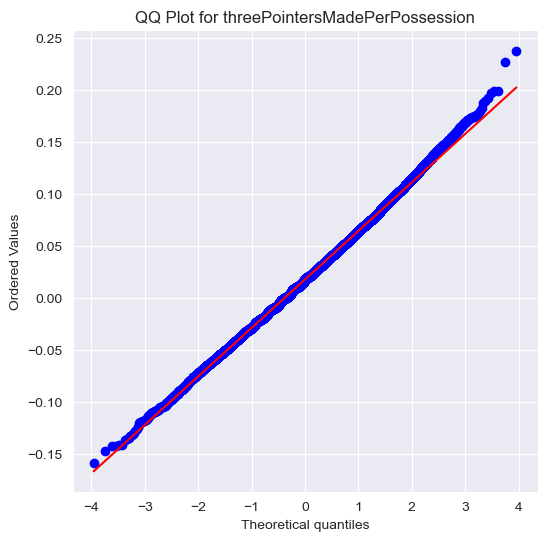

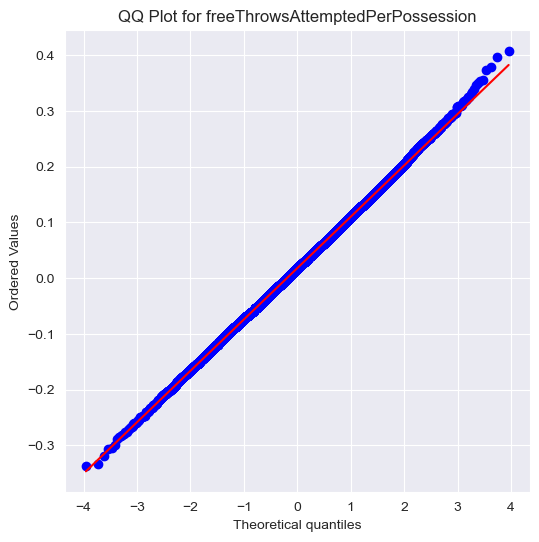

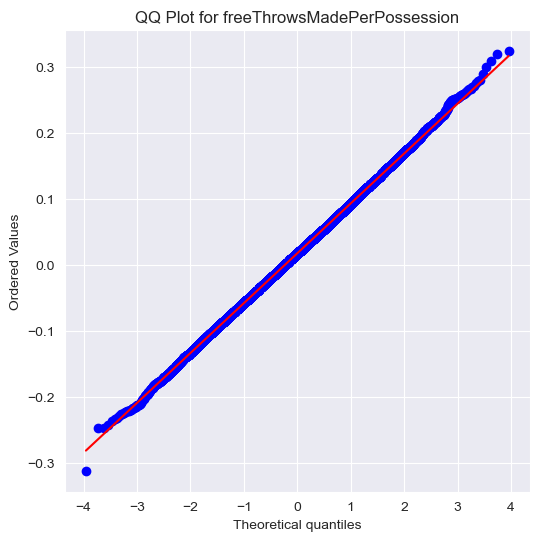

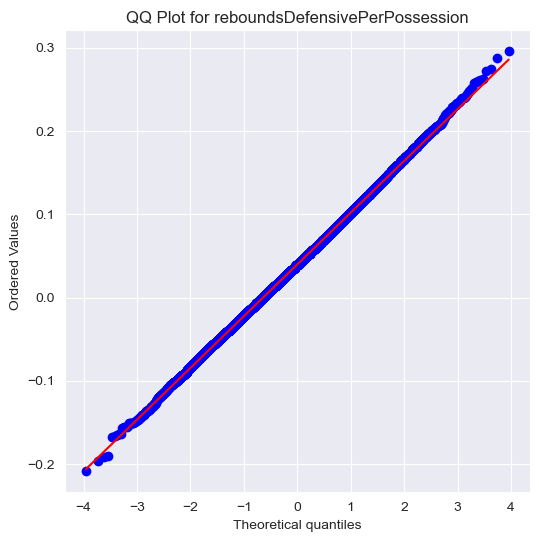

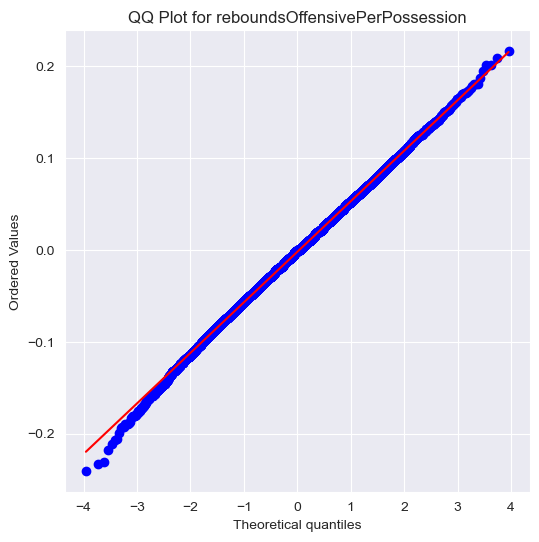

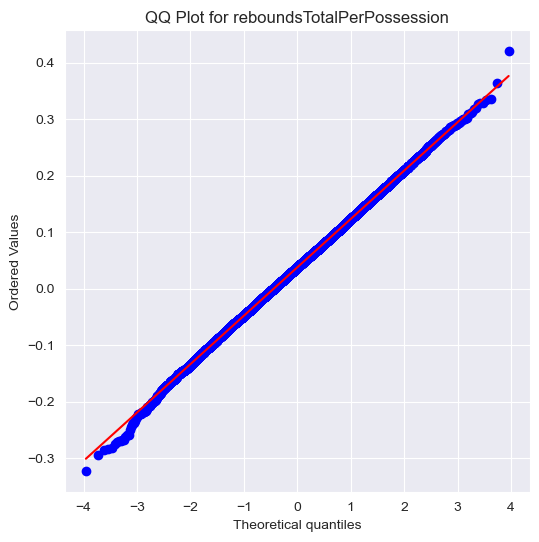

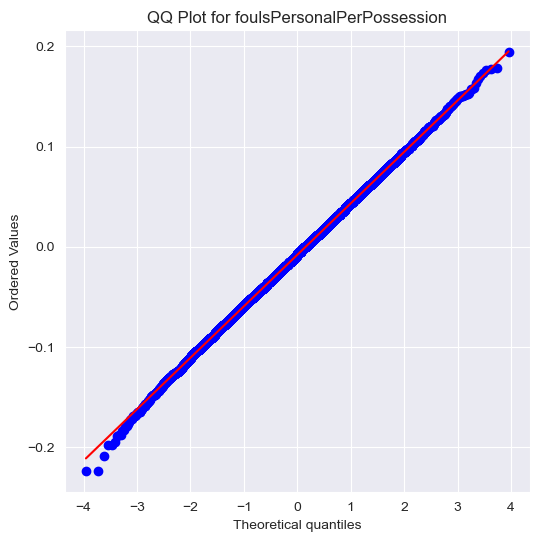

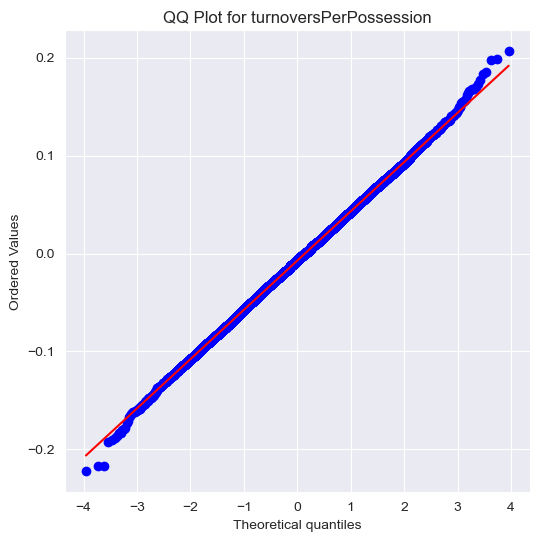

In [18]:
# Plot QQ Plots
for col in differences_2000.columns:
    plt.figure(figsize=(6, 6))
    stats.probplot(differences_2000[col], dist="norm", plot=plt)
    plt.title(f"QQ Plot for {col}")
    plt.show()

In [19]:
# Perform ttest of differences
from statsmodels.stats.multitest import multipletests
import pingouin as pg

results_2000 = []
for col in cols:
    diffs = differences_2000[col]

    if col == "teamScorePerPossession":
        res = pg.wilcoxon(diffs)
        statistic = res['W-val'].iloc[0]
        p_value = res['p-val'].iloc[0]
        effect_size = res['RBC'].iloc[0]
    else:
        statistic, p_value = stats.ttest_1samp(diffs, 0)
        effect_size = diffs.mean() / diffs.std(ddof=1)
    results_2000.append({
        'col': col,
        'mean_diff': diffs.mean(),
        'std_diff': diffs.std(ddof=1),
        't_statistic': statistic,
        'p_value': p_value,
        'effect_size': effect_size
    })

results_2000_df = pd.DataFrame(results_2000)

# Bonferri Correction
results_2000_df['corrected_p_value'] = multipletests(results_2000_df['p_value'], method='bonferroni')[1]
results_2000_df = results_2000_df.sort_values('effect_size', ascending=False).reset_index(drop=True)
results_2000_df

,col,mean_diff,std_diff,t_statistic,p_value,effect_size,corrected_p_value
0,teamScorePerPossession,0.119123,0.089084,900473.000000,0.000000e+00,0.989183,0.000000e+00
1,fieldGoalsPercentage,0.049374,0.059261,112.544256,0.000000e+00,0.833158,0.000000e+00
2,fieldGoalsMadePerPossession,0.041360,0.051748,107.964785,0.000000e+00,0.799257,0.000000e+00
3,reboundsDefensivePerPossession,0.039923,0.062149,86.773537,0.000000e+00,0.642379,0.000000e+00
4,assistsPerPossession,0.033162,0.061645,72.668054,0.000000e+00,0.537957,0.000000e+00
5,threePointersPercentage,0.061832,0.123279,67.751365,0.000000e+00,0.501559,0.000000e+00
6,reboundsTotalPerPossession,0.038030,0.085581,60.027081,0.000000e+00,0.444377,0.000000e+00
7,threePointersMadePerPossession,0.017990,0.046651,52.091545,0.000000e+00,0.385631,0.000000e+00
8,freeThrowsMadePerPossession,0.018415,0.075556,32.921977,5.826882e-231,0.243719,1.048839e-229
9,blocksPerPossession,0.008518,0.035026,32.851742,5.167769e-230,0.243199,9.301984e-229


In [20]:
results_df

,col,mean_diff,std_diff,t_statistic,p_value,effect_size,corrected_p_value
0,teamScorePerPossession,0.117938,0.086893,5.746890e+06,0.000000e+00,0.988535,0.000000e+00
1,fieldGoalsPercentage,0.050014,0.061695,1.715419e+02,0.000000e+00,0.810668,0.000000e+00
2,fieldGoalsMadePerPossession,0.040324,0.053101,1.606879e+02,0.000000e+00,0.759374,0.000000e+00
3,reboundsDefensivePerPossession,0.039940,0.063379,1.333482e+02,0.000000e+00,0.630173,0.000000e+00
4,assistsPerPossession,0.036166,0.064055,1.194733e+02,0.000000e+00,0.564603,0.000000e+00
5,reboundsTotalPerPossession,0.037491,0.088936,8.920243e+01,0.000000e+00,0.421550,0.000000e+00
6,threePointersPercentage,0.065415,0.191118,7.242699e+01,0.000000e+00,0.342273,0.000000e+00
7,freeThrowsMadePerPossession,0.025506,0.080819,6.678222e+01,0.000000e+00,0.315597,0.000000e+00
8,threePointersMadePerPossession,0.011794,0.041182,6.059972e+01,0.000000e+00,0.286380,0.000000e+00
9,freeThrowsAttemptedPerPossession,0.026752,0.099195,5.706731e+01,0.000000e+00,0.269687,0.000000e+00


Limiting ourselves to only games from 2000 and after, we do see a slight shift where three pointers are becoming more important than total rebounds.

# Collinearity

In [23]:
# Drop non-boxscore columns
box_score_2000 = team_statistics_df_2000.drop(columns=["gameId", "gameDate", "teamCity", "teamName", "teamId", "opponentTeamName", "opponentTeamCity", "opponentTeamId", "opponentTeamName"])
# Drop all normal boxscore columns in favor for PerPossession stats
box_score_2000 = box_score_2000.filter(regex=r'(PerPossession|Percentage)$')

corr_2000 = box_score_2000.corr().abs()
high_corr = (
    corr_2000.where(np.triu(np.ones(corr_2000.shape), k=1).astype(bool))
        .stack()
        .loc[lambda s: s > 0.75]
        .sort_values(ascending=False)
)
print(high_corr)

freeThrowsAttemptedPerPossession     freeThrowsMadePerPossession       0.923276
fieldGoalsPercentage                 fieldGoalsMadePerPossession       0.834562
teamScorePerPossession               fieldGoalsMadePerPossession       0.827767
threePointersAttemptedPerPossession  threePointersMadePerPossession    0.799212
fieldGoalsPercentage                 teamScorePerPossession            0.794746
reboundsDefensivePerPossession       reboundsTotalPerPossession        0.787838
dtype: float64


In [24]:
# Drop highly correlated columns
box_score_2000 = box_score_2000.drop(columns=["teamScorePerPossession", "fieldGoalsMadePerPossession", "freeThrowsMadePerPossession", "threePointersMadePerPossession", "reboundsTotalPerPossession"])

We decided to drop all the "MadePerPossession" columns because that metric essentially is explained already via Attempts/Possesion and Percentage, since thats the product of "MadePerPossession". We also decided to drop "ReboundsTotalPerPossession", because we have that metric via defensive and offensive rebounds.

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame({
    'variable': box_score_2000.columns,
    'VIF': [variance_inflation_factor(box_score_2000.values, i) for i in range(box_score_2000.shape[1])]
}).sort_values('VIF', ascending=False)
print(vif)

                               variable         VIF
6      fieldGoalsAttemptedPerPossession  223.011068
12               turnoversPerPossession   18.775097
10       reboundsOffensivePerPossession   18.169969
8      freeThrowsAttemptedPerPossession   13.459619
0                  fieldGoalsPercentage    2.045834
3                  assistsPerPossession    1.905099
1               threePointersPercentage    1.361455
7   threePointersAttemptedPerPossession    1.200348
9        reboundsDefensivePerPossession    1.126565
5                   stealsPerPossession    1.079864
11           foulsPersonalPerPossession    1.078718
4                   blocksPerPossession    1.041566
2                  freeThrowsPercentage    1.011794


In [26]:
box_score_2000 = box_score_2000.drop(columns=["fieldGoalsAttemptedPerPossession"])
vif = pd.DataFrame({
    'variable': box_score_2000.columns,
    'VIF': [variance_inflation_factor(box_score_2000.values, i) for i in range(box_score_2000.shape[1])]
}).sort_values('VIF', ascending=False)
print(vif)

                               variable         VIF
0                  fieldGoalsPercentage  113.140850
2                  freeThrowsPercentage   45.754745
3                  assistsPerPossession   41.785878
8        reboundsDefensivePerPossession   38.544723
10           foulsPersonalPerPossession   23.386032
1               threePointersPercentage   19.496983
11               turnoversPerPossession   15.747395
7      freeThrowsAttemptedPerPossession   12.272598
6   threePointersAttemptedPerPossession   11.571347
9        reboundsOffensivePerPossession    8.505313
5                   stealsPerPossession    8.176431
4                   blocksPerPossession    4.904153


# Linear Regression

In [27]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

features = [c for c in team_statistics_df.columns if (c.endswith("PerPossession") or c.endswith("Percentage"))]
features = [feature for feature in features if not feature.endswith("MadePerPossession")]
features.remove("teamScorePerPossession")
X = team_statistics_df_2000[features]
y = team_statistics_df_2000["win"]
features = X.columns

logit = make_pipeline(
    StandardScaler(),
    LogisticRegressionCV(cv=5, penalty='l1', solver='saga', scoring='roc_auc', max_iter=100000)
)
logit.fit(X, y)
coefs = logit.named_steps['logisticregressioncv'].coef_.ravel()
importance = pd.Series(abs(coefs), index=X.columns).sort_values(ascending=False)
print(importance)

fieldGoalsPercentage                   1.740963e+00
reboundsTotalPerPossession             1.090695e+00
stealsPerPossession                    1.090179e+00
reboundsDefensivePerPossession         9.570295e-01
freeThrowsAttemptedPerPossession       7.280583e-01
threePointersPercentage                6.154853e-01
turnoversPerPossession                 5.481431e-01
freeThrowsPercentage                   4.465540e-01
blocksPerPossession                    3.235013e-01
foulsPersonalPerPossession             2.322323e-01
assistsPerPossession                   1.621823e-01
threePointersAttemptedPerPossession    8.606510e-02
fieldGoalsAttemptedPerPossession       3.868497e-06
reboundsOffensivePerPossession         6.664144e-08
dtype: float64


# Tree Based Model

In [28]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
rf = RandomForestClassifier(n_estimators=200).fit(X_train, y_train)
perm = permutation_importance(rf, X_test, y_test, n_repeats=30, scoring='roc_auc')
importance = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)
print(importance)


fieldGoalsPercentage                   0.133533
reboundsDefensivePerPossession         0.062447
stealsPerPossession                    0.044944
reboundsTotalPerPossession             0.034999
freeThrowsAttemptedPerPossession       0.020179
threePointersPercentage                0.015282
turnoversPerPossession                 0.008405
freeThrowsPercentage                   0.005630
blocksPerPossession                    0.004390
assistsPerPossession                   0.003653
foulsPersonalPerPossession             0.001743
threePointersAttemptedPerPossession    0.000463
reboundsOffensivePerPossession         0.000153
fieldGoalsAttemptedPerPossession       0.000073
dtype: float64


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


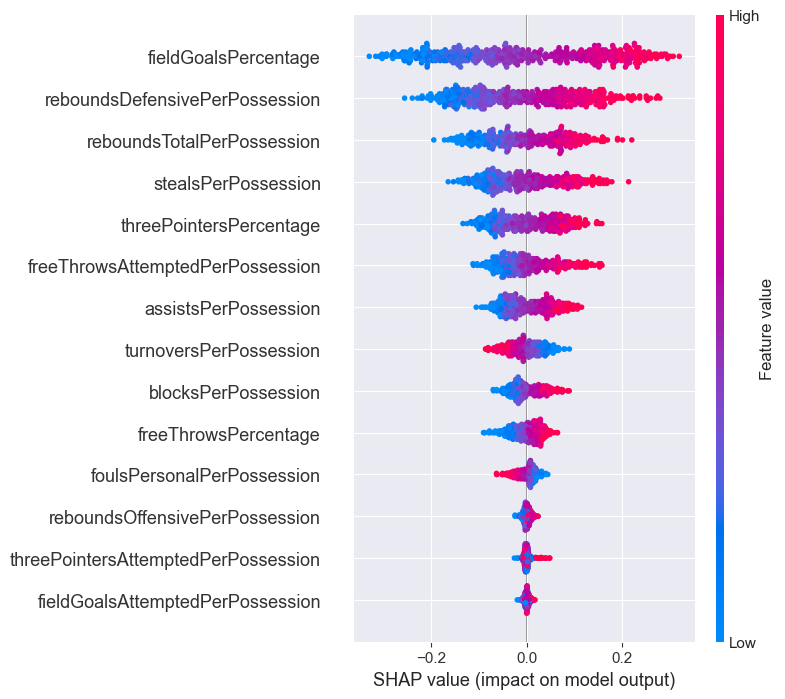

In [29]:
import shap
explainer = shap.TreeExplainer(rf)
# only explain 500 examples instead of, say, 10,000
X_small = X_test.sample(n=500, random_state=42)
shap_vals = explainer.shap_values(X_small)
shap.summary_plot(shap_vals[1], X_small)   # class=1 = win

# LDA

LDA coefficients (sorted by magnitude):
stealsPerPossession                    34.023974
fieldGoalsPercentage                   28.164611
reboundsDefensivePerPossession         19.325927
reboundsTotalPerPossession             12.791371
turnoversPerPossession                 12.474757
blocksPerPossession                    11.736795
freeThrowsAttemptedPerPossession        9.788753
foulsPersonalPerPossession              5.722944
threePointersPercentage                 5.621108
freeThrowsPercentage                    3.969565
assistsPerPossession                    2.886469
reboundsOffensivePerPossession          2.459402
threePointersAttemptedPerPossession     0.749006
fieldGoalsAttemptedPerPossession        0.048569
dtype: float64


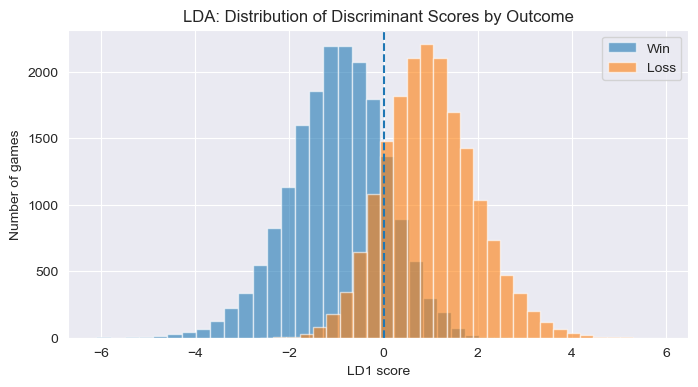

In [31]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=1)
X_lda = lda.fit_transform(X, y)
coef = pd.Series(lda.coef_[0], index=features)
print("LDA coefficients (sorted by magnitude):")
print(coef.abs().sort_values(ascending=False))

plt.figure(figsize=(8,4))
plt.hist(X_lda[y==1], bins=30, alpha=0.6, label="Win")
plt.hist(X_lda[y==0], bins=30, alpha=0.6, label="Loss")
plt.axvline(0, linestyle="--")             # cutoff at score=0
plt.legend()
plt.title("LDA: Distribution of Discriminant Scores by Outcome")
plt.xlabel("LD1 score")
plt.ylabel("Number of games")
plt.show()

# Conclusions over all models

fieldGoalPercentage (and, by extension threePointPercentage because it is highly correlated and few models still value threePointPercentage pretty high) and rebounding (especially defensive) seem to be the most important factors. Defensive Rebounding can make sense in a way of thinking when the opposing team shoots poorly, the team will get more defensive rebounds. So it is a way of measuring the defense of a team. Also, fieldGoals and threePointersAttempted do not matter at all, which suggests all we need to know is the efficiency (FG%, 3P%) of a team to infer its winning probability of that game for shooting statistics. freeThrowsAttempted does matter however, because it is not simply a shooting metric - it tells us how many fouls the team is drawing
